In [1]:
import tensorflow as tf
import cv2
import os
import sys
import random
import numpy as np
import glob

from tqdm import tqdm
import tifffile as tif
from PIL import Image
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import Model

%matplotlib inline

In [2]:
train_images_src = 'DIPLOMA/Dataset_for_train/images/'
train_masks_src = 'DIPLOMA/Dataset_for_train/masks/'

test_images_src = 'DIPLOMA/Dataset_for_test/images/'
test_masks_src = 'DIPLOMA/Dataset_for_test/masks/'

In [3]:
def read_images_to_array(folder_path):
    images = []
    # Проходим по всем файлам в папке
    for filename in os.listdir(folder_path):
        # Полный путь к изображению
        image_path = os.path.join(folder_path, filename)
        # Читаем изображение
        img = cv2.imread(image_path)
        if img is not None:
            # Преобразуем изображение в массив NumPy и добавляем в список
            images.append(img)
    # Преобразуем список изображений в массив NumPy
    images_array = np.array(images)
    return images_array

def read_masks_to_array(folder_path):
    images = []
    # Проходим по всем файлам в папке
    for filename in os.listdir(folder_path):
        # Полный путь к изображению
        image_path = os.path.join(folder_path, filename)
        # Читаем изображение
        img = cv2.imread(image_path, 0)
        if img is not None:
            # Преобразуем изображение в массив NumPy и добавляем в список
            images.append(img)
    # Преобразуем список изображений в массив NumPy
    images_array = np.array(images)
    return images_array

train_images = read_images_to_array(train_images_src)
train_masks = read_masks_to_array(train_masks_src)

test_images = read_images_to_array(test_images_src)
test_masks = read_masks_to_array(test_masks_src)

In [4]:
len(train_images), len(train_masks), len(test_images), len(test_masks)

(4577, 4577, 309, 309)

In [5]:
train_images[0].shape, train_masks[0].shape, test_images[0].shape, test_masks[0].shape

((256, 256, 3), (256, 256), (256, 256, 3), (256, 256))

In [6]:
# Нормализуем
x = train_images/255
y = train_masks/255

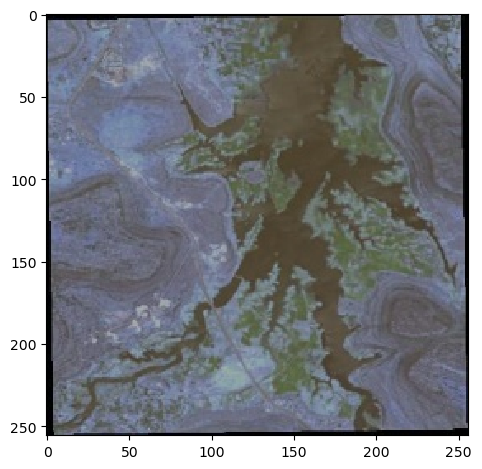

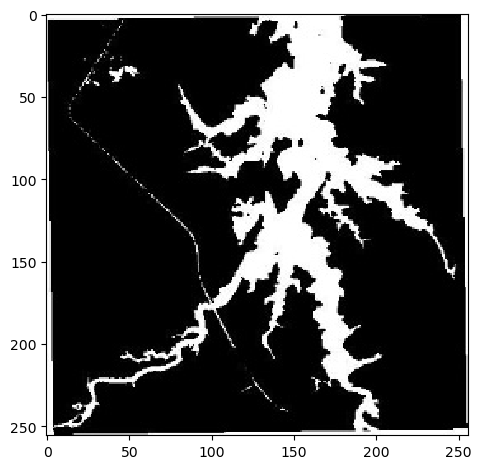

In [7]:
random_num = random.randint(0,516)
imshow(x[random_num])
plt.show()
imshow(y[random_num])
plt.show() 

test_img = x[random_num]
test_img2 = y[random_num]

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, BatchNormalization, Activation, Add, Dropout

def initial_block(inputs):
    conv = Conv2D(13, (3, 3), padding='same')(inputs)
    batch_norm = BatchNormalization()(conv)
    relu = Activation('relu')(batch_norm)
    return relu

def bottleneck(inputs, output_channels, downsampling=False, dilated=False, asymmetric=False, dropout_rate=0.1):
    stride = 2 if downsampling else 1
    kernel_size = (1, 1)
    
    if not asymmetric and not dilated:
        conv = Conv2D(output_channels, kernel_size, strides=(stride, stride), padding='same')(inputs)
    elif asymmetric:
        conv = Conv2D(output_channels, (5, 1), strides=(stride, stride), padding='same')(inputs)
        conv = Conv2D(output_channels, (1, 5), strides=(stride, stride), padding='same')(conv)
    elif dilated:
        conv = Conv2D(output_channels, kernel_size, dilation_rate=(2, 2), padding='same')(inputs)
        
    batch_norm = BatchNormalization()(conv)
    relu = Activation('relu')(batch_norm)
    
    conv = Conv2D(output_channels, kernel_size, padding='same')(relu)
    batch_norm = BatchNormalization()(conv)
    relu = Activation('relu')(batch_norm)
    
    conv = Conv2D(output_channels * 4, (1, 1), padding='same')(relu)
    batch_norm = BatchNormalization()(conv)
    relu = Activation('relu')(batch_norm)
    
    if downsampling:
        residual = Conv2D(output_channels * 4, (1, 1), strides=(stride, stride), padding='same')(inputs)
    elif inputs.shape[-1] != output_channels * 4:
        residual = Conv2D(output_channels * 4, (1, 1), padding='same')(inputs)
    else:
        residual = inputs
    
    if dropout_rate > 0:
        relu = Dropout(dropout_rate)(relu)
    
    return Add()([residual, relu])


def build_enet(input_shape=(256, 256, 3), num_classes=2):
    inputs = Input(shape=input_shape)
    
    initial = initial_block(inputs)
    
    bottleneck1 = bottleneck(initial, 16, downsampling=True)
    bottleneck2 = bottleneck(bottleneck1, 64, downsampling=True)
    bottleneck3 = bottleneck(bottleneck2, 128, downsampling=True)
    bottleneck4 = bottleneck(bottleneck3, 256, dilated=True)
    bottleneck5 = bottleneck(bottleneck4, 512, asymmetric=True)
    bottleneck6 = bottleneck(bottleneck5, 256)
    
    upsample1 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(bottleneck6)
    upsample1 = BatchNormalization()(upsample1)
    upsample1 = Activation('relu')(upsample1)
    
    upsample2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(upsample1)
    upsample2 = BatchNormalization()(upsample2)
    upsample2 = Activation('relu')(upsample2)
    
    upsample3 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(upsample2)
    upsample3 = BatchNormalization()(upsample3)
    upsample3 = Activation('relu')(upsample3)
    
    conv_output = Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(upsample3)
    
    model = Model(inputs=inputs, outputs=conv_output)
    return model

In [11]:
def get_model():
    return build_enet(input_shape=(256, 256, 3), num_classes=2)

In [12]:
model = get_model()

In [13]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history=model.fit(x_train,
          y_train,
          batch_size=10, 
          epochs=30,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/30
367/367 [==============================] - 84s 207ms/step - loss: 0.3468 - accuracy: 0.6472 - val_loss: 0.4437 - val_accuracy: 0.5977
Epoch 2/30
367/367 [==============================] - 71s 195ms/step - loss: 0.2997 - accuracy: 0.6661 - val_loss: 0.5923 - val_accuracy: 0.5792
Epoch 3/30
367/367 [==============================] - 71s 193ms/step - loss: 0.2900 - accuracy: 0.6684 - val_loss: 0.2995 - val_accuracy: 0.6836
Epoch 4/30
367/367 [==============================] - 71s 193ms/step - loss: 0.2873 - accuracy: 0.6686 - val_loss: 0.3397 - val_accuracy: 0.6379
Epoch 5/30
367/367 [==============================] - 72s 196ms/step - loss: 0.2764 - accuracy: 0.6729 - val_loss: 0.7794 - val_accuracy: 0.5578
Epoch 6/30
367/367 [==============================] - 72s 196ms/step - loss: 0.2761 - accuracy: 0.6725 - val_loss: 0.3151 - val_accuracy: 0.6429
Epoch 7/30
367/367 [==============================] - 72s 196ms/step - loss: 0.2719 - accuracy: 0.6748 - val_loss: 1.0232 - val_ac

In [ ]:
model.save("ENet_256_auged.h5")